In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()

In [4]:
data = load_coco_data(pca_features=True)

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_captions <class 'numpy.ndarray'> (195954, 17) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
train_urls <class 'numpy.ndarray'> (82783,) <U63
word_to_idx <class 'dict'> 1004
idx_to_word <class 'list'> 1004
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
val_features <class 'numpy.ndarray'> (40504, 512) float32


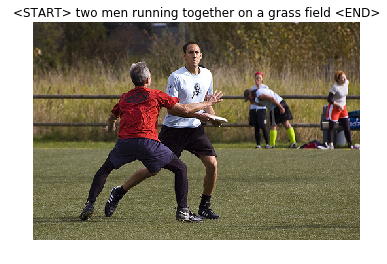

In [6]:
show_image(1)

In [7]:
def sparse_to_one_hot(sparse_input, max_dim):
    one_hot = np.zeros((sparse_input.shape[0], max_dim))
    for idx, input_index in enumerate(sparse_input):
        one_hot[idx, input_index] = 1
    return one_hot

def captions_to_one_hot(captions, vocab_dim):
    return [sparse_to_one_hot(sentence, vocab_dim) for sentence in captions]

def verify_caption_train_target_offset(train_caption, target_caption):
    for i in range(len(target_caption) - 1):
        assert train_caption[i + 1] == target_caption[i]

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]

## model params
word_embedding_dim = 256
hidden_dim = 512
learning_rate = 5e-4

def get_train_target_caption(train_captions_as_word_ids):
    """
        Convert training data:
        '<START> a variety of fruits and vegetables sitting on a kitchen counter'
        to target:
        'a variety of fruits and vegetables sitting on a kitchen counter <END>'
    """
    target_captions_as_word_ids = train_captions_as_word_ids[:, 1:]
    train_captions_as_word_ids = train_captions_as_word_ids[:, :-1]
    verify_caption_train_target_offset(train_captions_as_word_ids[0], target_captions_as_word_ids[0])
    not_null_target_mask = target_captions_as_word_ids != NULL_ID
    return train_captions_as_word_ids, target_captions_as_word_ids, not_null_target_mask

    

## Model

In [9]:
# Word Input
sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)
embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32)
word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, image_feature_dim, 'image_proj')
initial_cell_state = image_projection * 0
initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(initial_cell_state, image_projection)


In [10]:
# LSTM
cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
outputs, _ = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)
hidden_to_word = layer_utils.affine_transform(outputs, vocab_dim, 'hidden_to_word')

# Process entropy from logits and one-hot target
sy_caption_target = tf.placeholder(shape=[None, None], name="caption_target", dtype=tf.int64)
target_one_hot = tf.one_hot(sy_caption_target, vocab_dim, dtype=tf.int64)
raw_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=target_one_hot, logits=hidden_to_word)

# Apply not-null mask to ignore cross-entropy on trailing padding
sy_target_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
mask_not_null = tf.cast(sy_target_mask, dtype=tf.float32)
masked_cross_entropy = raw_cross_entropy * mask_not_null

# Get average cross entropy over caption 
cross_entropy = tf.reduce_mean(tf.reduce_sum(masked_cross_entropy, axis=1))
update_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction accuracy
total_predictions = tf.cast(tf.reduce_sum(mask_not_null), tf.float32)
prediction = tf.argmax(hidden_to_word, axis = 2)
correct_pred = tf.equal(prediction, sy_caption_target)
accuracy = tf.reduce_sum(tf.cast(correct_pred, tf.float32)) / total_predictions

print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
print("hidden lstm: ", hidden_to_word)

print("\n-- Loss tensors --")
print("Target one hot: ", target_one_hot)
print("Mask not null: ", mask_not_null)
print("Raw cross entropy: ", raw_cross_entropy)
print("Masked cross entropy: ", cross_entropy)
print("Cross entropy: ", cross_entropy)

print("\n-- Prediction tensors --")
print("target given: ", sy_caption_target)
print("correct_pred prediction shape:", accuracy)


-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 256), dtype=float32)
hidden lstm:  Tensor("hidden_to_word/dense/BiasAdd:0", shape=(?, ?, 1004), dtype=float32)

-- Loss tensors --
Target one hot:  Tensor("one_hot:0", shape=(?, ?, 1004), dtype=int64)
Mask not null:  Tensor("Cast_1:0", shape=(?, ?), dtype=float32)
Raw cross entropy:  Tensor("Reshape_2:0", shape=(?, ?), dtype=float32)
Masked cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)
Cross entropy:  Tensor("Mean:0", shape=(), dtype=float32)

-- Prediction tensors --
target given:  Tensor("caption_target:0", shape=(?, ?), dtype=int64)
correct_pred prediction shape: Tensor("truediv:0", shape=(), dtype=float32)


In [11]:
def sample_caption(session, initial_word, image_feature, limit_length):
    
    generated_word_idx = []
    for _ in range(limit_length):
        caption_input = [[initial_word]]
        pred = session.run(prediction,feed_dict =
                           {sy_caption_input: caption_input,
                           sy_image_feat_input: image_feature
                           })[0][0]
        
        if type(initial_word) is list:
            next_word_input = np.zeros(len(initial_word))
            next_word_input[pred] = 1
            initial_word = next_word_input
        else:
            initial_word = pred

        generated_word_idx.append(pred)
    print (decode_captions(np.array(generated_word_idx), data['idx_to_word']))
    return generated_word_idx

In [12]:
def predict_output(session, caption, image_feature):
    pred = session.run(prediction,feed_dict =
                       {sy_caption_input: caption,
                        sy_image_feat_input: image_feature
                       })
    return pred
    

### Training

In [13]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [14]:
iter_num = 100
embeddings = []
for i in range(iter_num):
    mini_batch, features, url = sample_coco_minibatch(data,  batch_size=100, split='train')
    train_captions, target_captions, target_mask = get_train_target_caption(mini_batch)
    _, c, a = sess.run([update_op, cross_entropy, accuracy], feed_dict=
                       {sy_image_feat_input: features,
                        sy_caption_input: train_captions, 
                        sy_caption_target: target_captions,
                        sy_target_mask: target_mask
                       })
    print("iter {}, cross-entropy: {}, accuracy: {}".format(i, c, a))

iter 0, cross-entropy: 78.62191772460938, accuracy: 0.0026385225355625153
iter 1, cross-entropy: 75.37805938720703, accuracy: 0.0018298261566087604
iter 2, cross-entropy: 77.97586822509766, accuracy: 0.007067137863487005
iter 3, cross-entropy: 75.6523666381836, accuracy: 0.029999999329447746
iter 4, cross-entropy: 78.89698028564453, accuracy: 0.06956521421670914
iter 5, cross-entropy: 75.3370361328125, accuracy: 0.07992734014987946
iter 6, cross-entropy: 77.55073547363281, accuracy: 0.11345646530389786
iter 7, cross-entropy: 75.1801986694336, accuracy: 0.14556962251663208
iter 8, cross-entropy: 73.91914367675781, accuracy: 0.16285452246665955
iter 9, cross-entropy: 75.09671020507812, accuracy: 0.16771300137043
iter 10, cross-entropy: 77.21050262451172, accuracy: 0.1866319477558136
iter 11, cross-entropy: 74.34928894042969, accuracy: 0.17684021592140198
iter 12, cross-entropy: 71.9936294555664, accuracy: 0.18106617033481598
iter 13, cross-entropy: 71.92943572998047, accuracy: 0.20217588

#### Initializing weights around zero
Cross entropy reached 46 within 100 iterations when conditioning on image as hidden stage (cell state zero)

Cross entropy reached 50 within 100 iterations without conditioning on image
Model mostly learn to start with a, and END
#### Initialize random weights at mean 0, std = 1.0
Cross entropy started off really high 300, reaching 156, but words are more diversed, when 

In [15]:
decode_captions(predict_output(sess, [train_captions[9]], [features[9]])[0], data['idx_to_word'])

'a <UNK> <UNK> a <UNK> <UNK> <UNK> <UNK> <END>'

In [19]:
decode_captions(target_captions[9],data['idx_to_word'])

'a <UNK> with a toothbrush <UNK> a <UNK> and <UNK> <UNK> <END>'